In [2]:
! pip install geopandas

     |████████████████████████████████| 972kB 2.7MB/s 
     |████████████████████████████████| 14.7MB 301kB/s 
     |████████████████████████████████| 10.9MB 46.7MB/s 


In [2]:
! wget https://data.lacity.org/api/views/wjz9-h9np/rows.csv?accessType=DOWNLOAD

--2020-08-03 08:47:02--  https://data.lacity.org/api/views/wjz9-h9np/rows.csv?accessType=DOWNLOAD
Resolving data.lacity.org (data.lacity.org)... 52.206.68.26, 52.206.140.199, 52.206.140.205
Connecting to data.lacity.org (data.lacity.org)|52.206.68.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘rows.csv?accessType=DOWNLOAD’

WNLOAD                  [  <=>               ]  27.32M  3.66MB/s               ^C


In [3]:
! wget https://www2.census.gov/geo/tiger/TIGER2017//STATE/tl_2017_us_state.zip
! unzip tl_2017_us_state.zip


--2020-08-03 16:57:35--  https://www2.census.gov/geo/tiger/TIGER2017//STATE/tl_2017_us_state.zip
Resolving www2.census.gov (www2.census.gov)... 23.76.87.160, 2600:1417:76:497::208c, 2600:1417:76:490::208c
Connecting to www2.census.gov (www2.census.gov)|23.76.87.160|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘tl_2017_us_state.zip’

tl_2017_us_state.zi     [ <=>                ]   8.85M  --.-KB/s    in 0.1s    

2020-08-03 16:57:37 (77.8 MB/s) - ‘tl_2017_us_state.zip’ saved [9284383]

Archive:  tl_2017_us_state.zip
 extracting: tl_2017_us_state.cpg    
  inflating: tl_2017_us_state.dbf    
  inflating: tl_2017_us_state.prj    
  inflating: tl_2017_us_state.shp    
  inflating: tl_2017_us_state.shp.ea.iso.xml  
  inflating: tl_2017_us_state.shp.iso.xml  
  inflating: tl_2017_us_state.shp.xml  
  inflating: tl_2017_us_state.shx    


In [4]:
import numpy as np
import pandas as pd
import datetime as dt
import math
import matplotlib.pyplot as plt
import requests
import geopandas as gpd
import pickle
import seaborn as sns
import sys
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
pd.set_option('max_rows', 500)
np.set_printoptions(threshold=sys.maxsize)

In [5]:
states = gpd.read_file('/content/tl_2017_us_state.shp', crs="EPSG:4326")

In [6]:
states.head()

,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,3,5,54,01779805,54,WV,West Virginia,00,G4000,A,62265662566,489840834,+38.6472854,-080.6183274,"POLYGON ((-81.74725 39.09538, -81.74635 39.096..."
1,3,5,12,00294478,12,FL,Florida,00,G4000,A,138911437206,31398800291,+28.4574302,-082.4091478,"MULTIPOLYGON (((-82.98748 24.62538, -82.98748 ..."
2,2,3,17,01779784,17,IL,Illinois,00,G4000,A,143784114293,6211277447,+40.1028754,-089.1526108,"POLYGON ((-91.18529 40.63780, -91.17510 40.643..."
3,2,4,27,00662849,27,MN,Minnesota,00,G4000,A,206229176104,18944967530,+46.3158148,-094.1996628,"POLYGON ((-96.78438 46.63050, -96.78434 46.630..."
4,3,5,24,01714934,24,MD,Maryland,00,G4000,A,25150696145,6980371026,+38.9466584,-076.6744939,"POLYGON ((-77.45881 39.22027, -77.45866 39.220..."


We load the data as json instead of geojson because some table manipulations can cause the geodataframe to break, so turn it into a geodataframe at the end

In [ ]:
# Use this code to get data via API. 
# Register to get more than 1000 records at a time
# r = requests.get('https://data.lacity.org/resource/wjz9-h9np.json?$limit=50000', auth=('', ''))
# df = pd.DataFrame(r.json())

In [ ]:
df = pd.read_csv('/content/rows.csv?accessType=DOWNLOAD', low_memory=False)

In [ ]:
df.head()

,Ticket number,Issue Date,Issue time,Meter Id,Marked Time,RP State Plate,Plate Expiry Date,VIN,Make,Body Style,Color,Location,Route,Agency,Violation code,Violation Description,Fine amount,Latitude,Longitude,Agency Description,Color Description,Body Style Description
0,1103341116,12/21/2015,1251.0,NaN,NaN,CA,200304.0,NaN,HOND,PA,GY,13147 WELBY WAY,01521,1.0,4000A1,NO EVIDENCE OF REG,50.0,99999.0,99999.0,NaN,NaN,NaN
1,1103700150,12/21/2015,1435.0,NaN,NaN,CA,201512.0,NaN,GMC,VN,WH,525 S MAIN ST,1C51,1.0,4000A1,NO EVIDENCE OF REG,50.0,99999.0,99999.0,NaN,NaN,NaN
2,1104803000,12/21/2015,2055.0,NaN,NaN,CA,201503.0,NaN,NISS,PA,BK,200 WORLD WAY,2R2,2.0,8939,WHITE CURB,58.0,6439997.9,1802686.4,NaN,NaN,NaN
3,1104820732,12/26/2015,1515.0,NaN,NaN,CA,NaN,NaN,ACUR,PA,WH,100 WORLD WAY,2F11,2.0,000,17104h,NaN,6440041.1,1802686.2,NaN,NaN,NaN
4,1105461453,09/15/2015,115.0,NaN,NaN,CA,200316.0,NaN,CHEV,PA,BK,GEORGIA ST/OLYMPIC,1FB70,1.0,8069A,NO STOPPING/STANDING,93.0,99999.0,99999.0,NaN,NaN,NaN


From inspection of the first five records there are some columns containing NaNs and Latitude and Longitude are not in degrees and also contain placeholder values.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10499385 entries, 0 to 10499384
Data columns (total 22 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   Ticket number           object 
 1   Issue Date              object 
 2   Issue time              float64
 3   Meter Id                object 
 4   Marked Time             float64
 5   RP State Plate          object 
 6   Plate Expiry Date       float64
 7   VIN                     object 
 8   Make                    object 
 9   Body Style              object 
 10  Color                   object 
 11  Location                object 
 12  Route                   object 
 13  Agency                  float64
 14  Violation code          object 
 15  Violation Description   object 
 16  Fine amount             float64
 17  Latitude                float64
 18  Longitude               float64
 19  Agency Description      object 
 20  Color Description       object 
 21  Body Style Description  objec

In [ ]:
df.describe()

,Issue time,Marked Time,Plate Expiry Date,Agency,Fine amount,Latitude,Longitude
count,1.049514e+07,340870.000000,9.526289e+06,1.049776e+07,1.047932e+07,1.049938e+07,1.049938e+07
mean,1.196284e+03,1058.777323,1.884065e+05,5.197611e+01,7.043522e+01,5.530876e+06,1.594642e+06
std,4.743501e+02,226.387081,5.010784e+04,9.404579e+00,3.336542e+01,2.870658e+06,1.897801e+06
min,0.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,9.080000e+02,913.000000,2.016040e+05,5.100000e+01,6.300000e+01,6.421922e+06,1.822212e+06
50%,1.152000e+03,1040.000000,2.017070e+05,5.400000e+01,6.800000e+01,6.452041e+06,1.841981e+06
75%,1.504000e+03,1200.000000,2.018100e+05,5.500000e+01,7.300000e+01,6.475224e+06,1.858206e+06
max,2.359000e+03,2400.000000,9.201020e+05,9.900000e+01,1.100000e+03,4.042322e+09,4.042322e+09


In [ ]:
# Percentage of missing data
df.isna().sum()/len(df)*100

Ticket number              0.000000
Issue Date                 0.016153
Issue time                 0.040440
Meter Id                  74.342564
Marked Time               96.753429
RP State Plate             0.012363
Plate Expiry Date          9.268124
VIN                       99.844667
Make                       0.147561
Body Style                 0.123226
Color                      0.102168
Location                   0.029059
Route                      0.761073
Agency                     0.015525
Violation code             0.244852
Violation Description      0.477999
Fine amount                0.191068
Latitude                   0.000067
Longitude                  0.000067
Agency Description        93.814390
Color Description         94.043318
Body Style Description    93.871355
dtype: float64

In [ ]:
# Function to prepare the time values so that they can be parsed
def time_padding(time):
  '''Adds extra zeros until there are 4 characters'''
  time = str(int(time))
  return '0'*(4-len(time)) + time

In [ ]:
df['Issue time'].fillna(0, inplace=True)

# Apply padding to Issue_time
df['Issue time'] = df['Issue time'].apply(time_padding)
df['Datetime'] = pd.to_datetime(df['Issue Date'] + ' ' + df['Issue time'], 
                                format='%m/%d/%Y %H%M')
df = df.drop(['Issue Date', 'Issue time'], axis=1)

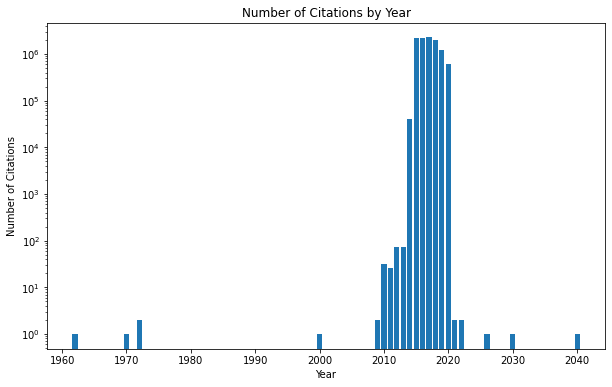

In [ ]:
plot_count = df['Datetime'].dt.year.value_counts().sort_index()
plt.figure(figsize=(10 ,6))
plt.bar(plot_count.index, plot_count)
plt.title('Number of Citations by Year')
plt.xlabel('Year')
plt.ylabel('Number of Citations')
plt.yscale('log')
plt.show()

Citations before 2008 and after 2020 are likely erroneous

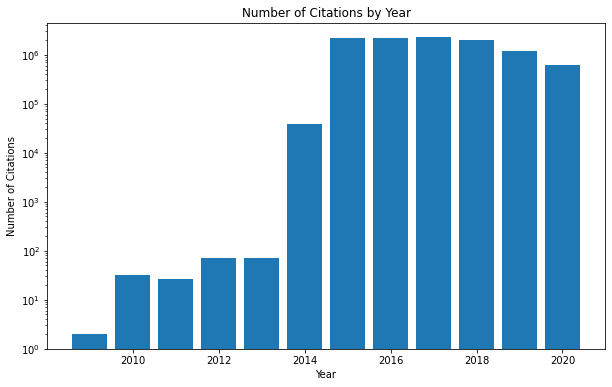

In [ ]:
mask = (df['Datetime'].dt.year > 2008) & (df['Datetime'].dt.year <= 2020)
plot_count = df.loc[mask,'Datetime'].dt.year.value_counts().sort_index()
plt.figure(figsize=(10 ,6))
plt.bar(plot_count.index, plot_count)
plt.title('Number of Citations by Year')
plt.xlabel('Year')
plt.ylabel('Number of Citations')
plt.yscale('log')
plt.show()

In [ ]:
df = df.loc[mask].reset_index(drop=True)

In [ ]:
df.head()

,Ticket number,Meter Id,Marked Time,RP State Plate,Plate Expiry Date,VIN,Make,Body Style,Color,Location,Route,Agency,Violation code,Violation Description,Fine amount,Latitude,Longitude,Agency Description,Color Description,Body Style Description,Datetime
0,1103341116,NaN,NaN,CA,200304.0,NaN,HOND,PA,GY,13147 WELBY WAY,01521,1.0,4000A1,NO EVIDENCE OF REG,50.0,99999.0,99999.0,NaN,NaN,NaN,2015-12-21 12:51:00
1,1103700150,NaN,NaN,CA,201512.0,NaN,GMC,VN,WH,525 S MAIN ST,1C51,1.0,4000A1,NO EVIDENCE OF REG,50.0,99999.0,99999.0,NaN,NaN,NaN,2015-12-21 14:35:00
2,1104803000,NaN,NaN,CA,201503.0,NaN,NISS,PA,BK,200 WORLD WAY,2R2,2.0,8939,WHITE CURB,58.0,6439997.9,1802686.4,NaN,NaN,NaN,2015-12-21 20:55:00
3,1104820732,NaN,NaN,CA,NaN,NaN,ACUR,PA,WH,100 WORLD WAY,2F11,2.0,000,17104h,NaN,6440041.1,1802686.2,NaN,NaN,NaN,2015-12-26 15:15:00
4,1105461453,NaN,NaN,CA,200316.0,NaN,CHEV,PA,BK,GEORGIA ST/OLYMPIC,1FB70,1.0,8069A,NO STOPPING/STANDING,93.0,99999.0,99999.0,NaN,NaN,NaN,2015-09-15 01:15:00


In [ ]:
df['Meter Id'].unique()[:100]

array([nan, 'WF55', 'WF54', 'WF177A', 'WF99', 'WF100', 'CB1463B', 'VH73',
       'VH220', 'VH14', '25', '45', '13', 'WF192', 'BF430', 'L80',
       'HO6630', 'HO6632', 'HO966', 'HO133', 'L233', 'L16940', 'LT72',
       'CC1235', 'CB3168', 'SW235', 'V6127', 'V27610', 'V117', 'V6125',
       'V74', 'V102', 'V6123', 'V166', 'V212', 'V207', 'V6126', 'V6128',
       'V111', 'PW442', 'OS164', 'OS142', 'OS467', 'OS162', 'OS570',
       'OS566', 'OS558', 'OS697', 'WS512', '11', 'WW2533', '36', 'WW303',
       'SVV345', '03', 'WU490', 'WU642', 'WU985A', 'SA117', 'SA115',
       'SA131', 'CB3695', 'WA654', 'WA663', 'VW303', 'VW302', 'VW607',
       'WA749', 'WA883', 'WA891', 'WA836', 'WA907', 'WA1324', 'WA1344',
       'WA1283', 'WA1278', 'WA1291', 'WA687', 'PR267', 'MM785', '30',
       'BF673', 'BF575', 'BF593A', 'BF697', 'SG72', 'SG87', 'SG99',
       'SG98', 'SG103', 'SG108', 'SG109', 'SG229', 'SG146', 'L213', 'L99',
       'L104', 'SVV52', 'SVV77', 'HW278'], dtype=object)

The 'Meter Id' column is missing nearly 75% of its data and includes 



In [ ]:
df['Marked Time'].unique()[:100]

array([  nan, 1122., 1145., 1124., 1130.,  820., 1817., 1110.,  944.,
        856., 1326.,  814.,  813.,  822.,  831.,  833.,  838.,  842.,
       1000.,  950.,  835.,  930.,  900.,  816.,  800.,  803.,  804.,
       1256.,  910.,  931.,  941., 1033., 1058., 1012., 1005., 1255.,
       1300., 1305., 1310., 1500., 1700., 1120., 1134., 1040., 1210.,
        955.,  940., 1119., 1057., 1101., 1104., 1113., 1242., 1254.,
       1357., 1346., 1447., 1458., 1545., 1555., 1630., 1035., 1045.,
       1105., 1100., 1313., 1311., 1230., 1240., 1316., 1050., 1054.,
       1109., 1206., 1218., 1014., 1021., 1022., 1150., 1055., 1009.,
       1328.,  855.,  854.,  925.,  933.,  810., 1013., 1007., 1131.,
       1155., 1200., 1039., 1037., 1115., 1220., 1140.,  839.,  849.,
        853.])

In [ ]:
df.loc[df['Marked Time'].notna(), 'Marked Time'].apply(time_padding).unique()[:100]

array(['1122', '1145', '1124', '1130', '0820', '1817', '1110', '0944',
       '0856', '1326', '0814', '0813', '0822', '0831', '0833', '0838',
       '0842', '1000', '0950', '0835', '0930', '0900', '0816', '0800',
       '0803', '0804', '1256', '0910', '0931', '0941', '1033', '1058',
       '1012', '1005', '1255', '1300', '1305', '1310', '1500', '1700',
       '1120', '1134', '1040', '1210', '0955', '0940', '1119', '1057',
       '1101', '1104', '1113', '1242', '1254', '1357', '1346', '1447',
       '1458', '1545', '1555', '1630', '1035', '1045', '1105', '1100',
       '1313', '1311', '1230', '1240', '1316', '1050', '1054', '1109',
       '1206', '1218', '1014', '1021', '1022', '1150', '1055', '1009',
       '1328', '0855', '0854', '0925', '0933', '0810', '1013', '1007',
       '1131', '1155', '1200', '1039', '1037', '1115', '1220', '1140',
       '0839', '0849', '0853', '0805'], dtype=object)

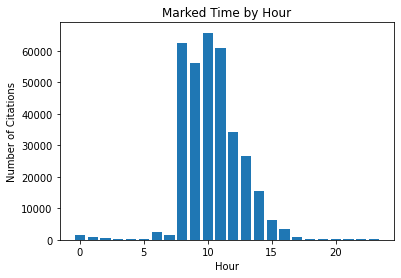

In [ ]:
time_counts = pd.to_datetime(df.loc[df['Marked Time'].notna(), 'Marked Time'].apply(time_padding), format='%H%M', errors='coerce').dt.hour.value_counts()
plt.bar(time_counts.index, time_counts)
plt.title('Marked Time by Hour')
plt.ylabel('Number of Citations')
plt.xlabel('Hour')
plt.show()

The 'Marked Time' column is missing 96% of its data. It consists of time stamps in a 24 hr format.

In [11]:
state_plate_df = df['RP State Plate'].value_counts().reset_index()
state_plate_df.columns = ['state', 'plate_count']

In [12]:
state_plate_df.head(10)

,state,plate_count
0,CA,9779535
1,AZ,93420
2,TX,66331
3,NV,61875
4,FL,46165
5,WA,41378
6,IL,29530
7,OR,29321
8,CO,26594
9,NY,19373


In [13]:
# Geopandas can calculate distance of nearby objects but distance objects
# need a different formula
def distance(source , destination): 
  '''Haversine formula for distance on a sphere in miles'''
  lat1, lon1 = source [0],source [1]
  lat2, lon2 = destination[0],destination[1]
  radius = 3956 # mi
  dlat = math.radians(lat2-lat1)
  dlon = math.radians(lon2-lon1)
  a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
      * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
  c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
  d = radius * c
  return d

In [14]:
# Formula to calculate distance between California and other states
def state_dist(state):
  '''Formula to calculate distance between CA and other states'''
  state_intersect = set(df['RP State Plate']).intersection(set(states.STUSPS))
  calif_coords = states.loc[states.STUSPS == 'CA', ['INTPTLAT', 'INTPTLON']].values.astype(float)[0]
  calif_dist_dict = { state.STUSPS : distance(calif_coords,(float(state.INTPTLAT),float(state.INTPTLON))) for ind, state in states.iterrows()}
  if state in state_intersect:
    return calif_dist_dict[state]
  else:
    return np.nan

In [26]:
state_plate_df['dist_ca'] = state_plate_df.state.apply(state_dist).round(1)
state_plate_df_inters = state_plate_df.loc[state_plate_df[state_plate_df.dist_ca.notna()].index]
state_plate_df_inters.head()

,state,plate_count,dist_ca
0,CA,9779535,0.0
1,AZ,93420,489.3
2,TX,66331,1218.5
3,NV,61875,218.6
4,FL,46165,2221.6


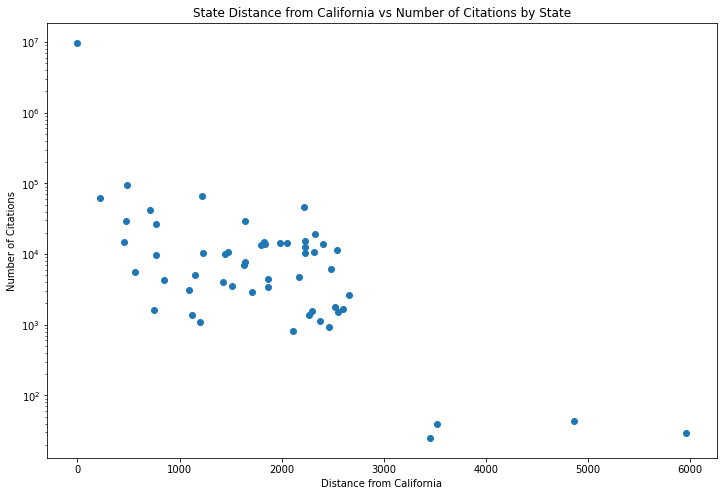

In [16]:
# Plot of distance between state of citation vehicle and CA vs number of citations
plt.figure(figsize=(12,8))
plt.scatter(state_plate_df.loc[state_plate_df_inters.index].dist_ca, 
            state_plate_df.loc[state_plate_df_inters.index, 'plate_count'])
plt.yscale('log')
plt.title('State Distance from California vs Number of Citations by State')
plt.ylabel('Number of Citations')
plt.xlabel('Distance from California')
plt.show()

The graph with the a log scale for the number of citations is roughly linear, so it would make sense to check the correlation of the log of the number of citations.

In [22]:
# Correlation table with log citation count
spdi_log = state_plate_df_inters.copy()
spdi_log['log_plate_count'] = spdi_log['plate_count'].apply(np.log)
spdi_log.corr().round(3)

,plate_count,dist_ca,log_plate_count
plate_count,1.000,-0.247,0.501
dist_ca,-0.247,1.000,-0.711
log_plate_count,0.501,-0.711,1.000


In [ ]:
# State/territory most distant from California
spdi_log.loc[spdi_log.dist_ca.idxmax()]

state                   GU
plate_count             29
dist_ca            5962.33
log_plate_count     3.3673
Name: 68, dtype: object

We find that the distance between the state where the car is from and the log of the number of citations of that state have a correlation of -0.71. So closer the state, the higher the number of citations, with California having 9.8M citations and Guam being 6K miles away and having only 29 citations total.

In [ ]:
df.loc[df['Plate Expiry Date'].notna(),'Plate Expiry Date'].astype(int).unique()[:100]

array([200304, 201512, 201503, 200316, 201507, 201605, 201602, 201701,
       201511, 201607, 201611, 201502, 201606, 201509, 201603, 201610,
       201601, 201510, 201506, 201604, 201608, 201508, 201504, 201505,
       201407, 201609, 201702, 201412, 201212, 200815, 201403, 201410,
       201501, 201905, 201612, 201408, 200906,      1,      8, 201712,
       201903, 201102,      3,      4,     12,      9,      6,      5,
       201304,      2,     11,      7,     10, 201706, 201206, 201307,
       201302, 200106, 201901, 201709, 200104, 201708, 200505, 201411,
       201704, 201110, 201101, 200105, 201308, 201106, 201705, 201409,
       201703, 201108, 201710, 201902, 201111, 201402, 209912, 201909,
       201707, 201404, 201405, 200103, 201309, 209009, 201209, 200615,
       201205, 200514, 201211, 201010, 200710, 200810, 200916, 200616,
       200716, 201311, 201711, 201103])

Plate expiry dates seem to be in the format 'year''month', but there are many examples of dates into the far future ie 2099 and months that go beyond 12. I'll parse the dates but add them as a separate column

The top state plates refer to California and neighboring states but there are a few anomalies like MX (probably referring to Mexico), AB (Alberta, Canada), and TT (tow truck).
http://www.nyc.gov/html/dof/html/pdf/faq/stars_codes.pdf

In [ ]:
df['Plate Expiry Date Parsed'] = pd.to_datetime(df['Plate Expiry Date'],format='%Y%m', errors='coerce')

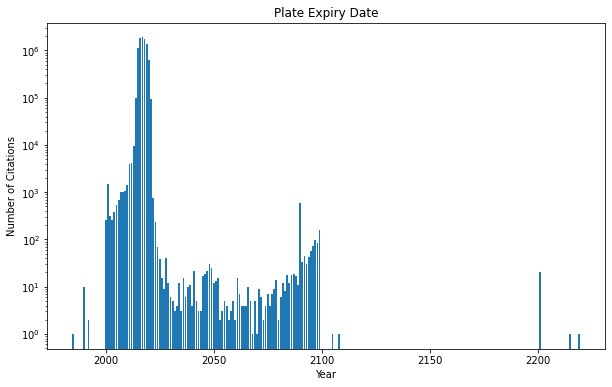

In [ ]:
plate_expiry = df['Plate Expiry Date Parsed'].dt.year.value_counts().sort_index()
plt.figure(figsize=(10 ,6))
plt.bar(plate_expiry.index, plate_expiry)
plt.title('Plate Expiry Date')
plt.xlabel('Year')
plt.ylabel('Number of Citations')
plt.yscale('log')
plt.show()

Car registry dates are only given 2 years into the future so at most they should only go up to 2022 and everything else should be filtered out

In [ ]:
df.loc[df['Plate Expiry Date Parsed'].dt.year > 2021, 'Plate Expiry Date Parsed'] = np.nan

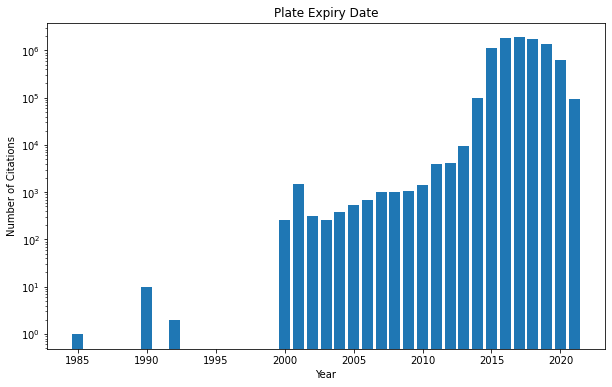

In [ ]:
plate_expiry = df['Plate Expiry Date Parsed'].dt.year.value_counts().sort_index()
plt.figure(figsize=(10 ,6))
plt.bar(plate_expiry.index, plate_expiry)
plt.title('Plate Expiry Date')
plt.xlabel('Year')
plt.ylabel('Number of Citations')
plt.yscale('log')
plt.show()

The early dates are kept because it seems very plausible that there are people driving around with expired plates.

In [10]:
df.loc[df['Plate Expiry Date Parsed'].notna()]

,Ticket number,Meter Id,Marked Time,RP State Plate,Plate Expiry Date,VIN,Make,Body Style,Color,Location,Route,Agency,Violation code,Violation Description,Fine amount,Latitude,Longitude,Agency Description,Color Description,Body Style Description,Datetime,Plate Expiry Date Parsed
0,1103341116,NaN,NaN,CA,200304.0,NaN,HOND,PA,GY,13147 WELBY WAY,01521,1.0,4000A1,NO EVIDENCE OF REG,50.0,9.999900e+04,9.999900e+04,NaN,NaN,NaN,2015-12-21 12:51:00,2003-04-01
1,1103700150,NaN,NaN,CA,201512.0,NaN,GMC,VN,WH,525 S MAIN ST,1C51,1.0,4000A1,NO EVIDENCE OF REG,50.0,9.999900e+04,9.999900e+04,NaN,NaN,NaN,2015-12-21 14:35:00,2015-12-01
2,1104803000,NaN,NaN,CA,201503.0,NaN,NISS,PA,BK,200 WORLD WAY,2R2,2.0,8939,WHITE CURB,58.0,6.439998e+06,1.802686e+06,NaN,NaN,NaN,2015-12-21 20:55:00,2015-03-01
5,1106226590,NaN,NaN,CA,201507.0,NaN,CHEV,VN,GY,SAN PEDRO S/O BOYD,1A35W,1.0,4000A1,NO EVIDENCE OF REG,50.0,9.999900e+04,9.999900e+04,NaN,NaN,NaN,2015-09-15 00:19:00,2015-07-01
6,1106500452,NaN,NaN,CA,201605.0,NaN,MAZD,PA,BL,SUNSET/ALVARADO,00217,1.0,8070,PARK IN GRID LOCK ZN,163.0,9.999900e+04,9.999900e+04,NaN,NaN,NaN,2015-12-17 17:10:00,2016-05-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10497668,1121859325,NaN,NaN,CA,202107.0,NaN,TOYO,PA,BK,727 N BROADWAY,1FB12,1.0,8056E4,NaN,93.0,6.489265e+06,1.844620e+06,WESTERN,BLACK,PASSENGER CAR,2020-07-18 18:38:00,2021-07-01
10497673,1113539571,NaN,NaN,CA,202008.0,NaN,JEEP,PA,GY,500 BUENA VISTA VIEW,NaN,4.0,22502A,NaN,63.0,6.492589e+06,1.849576e+06,HOLLYWOOD,GREY,PASSENGER CAR,2020-07-08 14:11:00,2020-08-01
10497674,1124973964,NaN,NaN,CA,202012.0,NaN,NISS,PA,WH,PCH S/O SUNSET,00008,1.0,8069A,NaN,93.0,9.999900e+04,9.999900e+04,WESTERN,NaN,PASSENGER CAR,2020-07-04 21:00:00,2020-12-01
10497675,1124974200,NaN,NaN,CA,202009.0,NaN,TOYO,PA,BL,PCH/PORTA MARINA,8A1,1.0,8069A,NaN,93.0,9.999900e+04,9.999900e+04,WESTERN,BLUE,PASSENGER CAR,2020-06-28 20:15:00,2020-09-01


In [ ]:
df['days_expired'] = (df.Datetime - df['Plate Expiry Date Parsed']).dt.days
expiry_viol_table = pd.concat([df.loc[df['days_expired'] > 0, 'Violation Description'].value_counts().reset_index()[:10],
          df['Violation Description'].value_counts().reset_index()[:10]], axis=1)
expiry_viol_table.columns = ['positive_days_expired_viol', 'violation_count', 'all', 'violation_count']

In [ ]:
# Table of top 10 violations for subset of data with expired car registration vs
# Top 10 of all citation violations
expiry_viol_table

,positive_days_expired_viol,violation_count,all,violation_count
0,DISPLAY OF TABS,549456,NO PARK/STREET CLEAN,2958564
1,NO PARK/STREET CLEAN,430457,METER EXP.,1841748
2,METER EXP.,227658,RED ZONE,831044
3,RED ZONE,102158,PREFERENTIAL PARKING,730678
4,NO EVIDENCE OF REG,96167,DISPLAY OF TABS,623349
5,PREFERENTIAL PARKING,90166,NO PARKING,464176
6,NO PARKING,60669,DISPLAY OF PLATES,290293
7,DISPLAY OF PLATES,37397,WHITE ZONE,229198
8,EXCEED 72HRS-ST,30100,PARKED OVER TIME LIMIT,204248
9,PARKED OVER TIME LIMIT,27660,NO STOP/STANDING,186972


In the table above, it would seem that if the difference between the citation date and the expiry date was positive, it would more likely be cited as a "DISPLAY OF TABS" violation. This could also explain why there are so many empty entries--officers are more likely to input this if their registration is expired.

In [ ]:
df.VIN.unique()[:100]

array([nan, '3225', '1068', '4286', '4683', '6904', '8788', '1856',
       '5884', '3427', '1655', '3266', '3490', '3980', '0277', '2850',
       '9233', '3019', '1153', '7978', '4608', '2807', '3687', '8628',
       '2016', '8835', '4889', '7344', '5302', '5534', '7323', '4434',
       '3N1BB41D5XL003388', '4151', '3931', '0645', '2674', '3391',
       '6412', '6768', '4871', '9864', '6333', '3757', '2785', '4253',
       '9315', '5364', '0962', '9207', '6086', '1598', '0285', '9446',
       '5090', '5261', '6638', '1376', '9698', '3554', '8784', '2917',
       '7981', '5512', '9995', '0156', '1HGCR2F57EA225553', '8917',
       '7320', '3949', '5028', '2567', '3928', '0365', '4008', '8096',
       '8619', '7466', '8001', '1048', '2433', '6969', '6523', '6073',
       'ZAMCE39A760021282', '3278', '7573', '8326', '1270', '0468',
       '7995', 'WBA3C1C9FK118236', '1254', '8908', '7187', '1348', '7760',
       '1010', '4498', '5620'], dtype=object)

In [ ]:
df.loc[df.VIN.str.len() > 4, 'VIN']

888200    3N1BB41D5XL003388
888294    1HGCR2F57EA225553
888318    ZAMCE39A760021282
888325     WBA3C1C9FK118236
888382    JTDKN3DUID1650769
                ...        
925925              COVERED
925927              COVERED
925932              COVERED
925933    JTHBW1GGXF2080614
925947    1N4AL3AP2EN224587
Name: VIN, Length: 3558, dtype: object

In [ ]:
df[df.VIN == '1N4AL3AP2EN224587']

,Ticket number,Meter Id,Marked Time,RP State Plate,Plate Expiry Date,VIN,Make,Body Style,Color,Location,Route,Agency,Violation code,Violation Description,Fine amount,Latitude,Longitude,Agency Description,Color Description,Body Style Description,Datetime,Plate Expiry Date Parsed
925947,4247320195,CB3067A,NaN,CA,NaN,1N4AL3AP2EN224587,NISS,PA,GY,355 4TH ST E,00667,56.0,88.13B+,METER EXP.,63.0,6485950.2,1840638.1,NaN,NaN,NaN,2014-11-03 11:10:00,NaT


In [ ]:
df.loc[df.VIN.str.len() > 4, 'Datetime'].dt.year.value_counts()

2014    3558
Name: Datetime, dtype: int64

Most of these VIN records are missing but of the ones that aren't missing, they consist of 4 numbers. Of the ones that are not 4 numbers, there are some that say "COVERED", or actual plausible VIN numbers. Web VIN lookup verifies that this VIN number seems to be correct. In fact, this car was cited the same year it was manufactured. Looking at the dates where we have full VIN numbers, which are all in 2014. VIN numbers are highly identifying information. It is possible that the process of deidentification did not properly take place in 2014.

In [ ]:
df.Make.value_counts()[:50]

TOYT    1733082
HOND    1184059
FORD     909365
NISS     754548
CHEV     716004
BMW      480513
MERZ     429649
VOLK     353890
HYUN     323880
DODG     310313
LEXS     297464
KIA      253014
JEEP     247563
AUDI     204226
MAZD     192762
OTHR     173227
GMC      150182
INFI     137697
CHRY     133251
ACUR     124777
SUBA     118489
VOLV      98955
TOYO      95343
MITS      87820
CADI      82383
MNNI      73888
LNDR      61881
PORS      54621
UNK       51027
FRHT      49100
BUIC      48745
LINC      44719
PONT      44560
GRUM      43213
STRN      41469
FIAT      38684
TSMR      33626
JAGU      32063
MERC      29306
RROV      21112
ISU       20761
INTL      17683
SUZI      14056
SAA       12913
OLDS      12154
LEXU      11397
MASE      11091
PTRB       7748
PLYM       7075
KW         6436
Name: Make, dtype: int64

In [33]:
df.groupby('Make')['Fine amount'].agg('sum').sort_values(ascending=False)[:20]

Make
TOYT    122630931.0
HOND     83289127.0
FORD     64353367.0
NISS     54010869.0
CHEV     50937663.0
BMW      31524088.0
MERZ     29142468.0
VOLK     23961292.0
HYUN     22999314.0
DODG     21996042.0
LEXS     20455507.0
KIA      18316834.0
JEEP     16990824.0
OTHR     13664605.0
AUDI     13588335.0
MAZD     13198179.0
GMC      11150287.0
INFI      9537313.0
CHRY      9490587.0
ACUR      8543186.0
Name: Fine amount, dtype: float64